In [0]:
import torch
torch.cuda.get_device_properties('cuda:0')

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [0]:
!pip install -q transformers

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import pandas as pd
import os

from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers.optimization import AdamW

from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
from multiprocessing.pool import ThreadPool

from collections import namedtuple
from time import perf_counter
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
IMG_SIZE = 128
PATH_TO_SAVE = 'drive/My Drive/image_captioning/'

## Создадим датасет

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r drive/My\ Drive/image_captioning/data .

In [0]:
transform = transforms.Compose([
     transforms.Resize((IMG_SIZE, IMG_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

class GCCDataset(Dataset):
    def __init__(self, path='data/Train_GCC-training.tsv', max_data_len=None, tokenizer=None, max_length=512, timeout=2):
        self.data = pd.read_csv(path, sep='\t', header=None, names=['desc', 'url'])#, nrows=max_data_len)
        if max_data_len:
            self.data = self.data.sample(frac=1).reset_index(drop=True).iloc[:max_data_len]
        print(len(self.data))
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        desc, url = self.data.iloc[idx]
        text_tok_ids = self.tokenizer.encode(desc, max_length=self.max_length)
        text_tok_ids.extend([self.tokenizer.eos_token_id])

        return url, text_tok_ids

In [0]:
def get_dataloader(dataset, batch_size, pad_elem, threads, img_transform=None, timeout=3):
    def pad(seq, max_len, pad_elem):
        return seq + [pad_elem] * max(0, max_len - len(seq))

    def get_image_from_url(url):
        try:
            response = requests.get(url, timeout=timeout)
            if response.ok and response.url == url:
                img = Image.open(BytesIO(response.content))
                return img_transform(img)
            return None
        except Exception as e:
            return None
    
    def collate_fn(batch_data):
        list_urls, list_ids = list(zip(*batch_data))

        list_imgs = threads.imap(get_image_from_url, list_urls) 
        list_imgs, list_ids = list(zip(*[(img, ids) for img, ids in zip(list_imgs, list_ids) 
                                                    if img is not None and img.size(0) == 3]))
        
        batch_img = torch.stack(list_imgs, 0)        

        batch_len = max(map(len, list_ids))
        batch_ids = torch.tensor(
            [pad(ids, batch_len, pad_elem) 
             for ids in list_ids]
        ).long()
        batch_mask = batch_ids.ne(pad_elem).int()

        return batch_img, batch_ids, batch_mask

    return DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True,
        collate_fn=collate_fn, pin_memory=True, num_workers=0 
    )

## Основные архитектуры

In [0]:
class Embedding(nn.Module):
    def __init__(self, cnn, embed_size):
        super().__init__()
        self.cnn = cnn
        self.embed_size = embed_size
        _, last_module = list(cnn.named_children())[-1]
        self.proj = nn.Linear(last_module.out_features, embed_size)

    def forward(self, x):
        x = self.cnn(x)
        return self.proj(x)

    def train(self, mode=True):
        self.cnn.train(mode)
        self.proj.train(mode)
        for param in self.cnn.parameters():
            param.requires_grad_(mode)

In [0]:
SPECIAL_TOKENS = ('img', 'desc', 'pad')

In [0]:
SpecialIds = namedtuple('speacil_ids', SPECIAL_TOKENS)

In [0]:
class Image2TextDescriptor(nn.Module):
    def __init__(self, pretrained_model_text='gpt2', 
                     pretrained_model_image='resnet18'):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.tokenizer, self.special_ids = self._build_tokenizer(pretrained_model_text)
        self.gpt2 = self._build_gpt2(len(self.tokenizer), pretrained_model_text)

        cnn = self._build_cnn(pretrained_model_image)
        self.embedding = Embedding(cnn, self.gpt2.config.hidden_size)#.to(device)
        self.to(device)

    def train(self, mode=True):
        self.embedding.train(mode)
        self.gpt2.train(mode)
        for param in self.gpt2.parameters():
            param.requires_grad_(mode)

    def save(self, path='weights/model_full_trained'):
        state = {
            'gpt_dict': self.gpt2.state_dict(),
            'embedding_dict': self.embedding.state_dict(),
            'tokenizer': self.tokenizer,
        }
        torch.save(state, path)
        #print('!!! model is saved !!!')

    def load(self, path='weights/model_full_trained'):
        state = torch.load(path)
        self.gpt2.load_state_dict(state['gpt_dict'])
        self.embedding.load_state_dict(state['embedding_dict'])
        self.tokenizer = state['tokenizer']
        #print('!!! model weights are loaded !!!')

    def forward(self, img_data, text_tok_ids, attn_mask=None):
        context_embeds = self.get_context_embeds(img_data)

        text_embeds = self.gpt2.transformer.wte(text_tok_ids)
        full_embeds = torch.cat((context_embeds, text_embeds), dim=1)
        
        labels_ids = self.get_labels(
            full_embeds.shape[:-1],
            context_embeds.size(1),
            text_tok_ids
        ).to(self.device)
        
        out = self.gpt2(inputs_embeds=full_embeds, labels=labels_ids, attention_mask=attn_mask)        
        return out

    def get_context_embeds(self, img_data):
        img_tok_emb, desc_tok_emb = self.gpt2.transformer.wte(
            torch.tensor([self.special_ids.img, self.special_ids.desc]).to(self.device)
        )

        img_embeds = self.embedding(img_data)[:, None, :] # new shape: (batch_size, seq_len, embed_size)
        context_embeds = torch.cat((img_tok_emb.expand_as(img_embeds), 
                                    img_embeds, 
                                    desc_tok_emb.expand_as(img_embeds)), dim=1)
        return context_embeds

    def get_labels(self, shape, context_len, tok_ids):
        labels_ids = torch.empty(shape, dtype=torch.long).fill_(-100) # -100 is mask value for labels in hugginface models
        mask = (tok_ids == self.special_ids.pad)
        labels_ids[:, context_len:] = tok_ids.masked_fill(mask, -100)

        return labels_ids

    def _build_tokenizer(self, pretrained_model):
        special_dct = {t: f"<{t.upper()}>" for t in SPECIAL_TOKENS}
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        tokenizer.add_special_tokens({'additional_special_tokens': list(special_dct.values())})
        special_ids = SpecialIds(**{k: tokenizer.encode(v)[0] for k, v in special_dct.items()})
        
        return tokenizer, special_ids

    def _build_gpt2(self, vocab_size, pretrained_model):
        gpt2 = AutoModelWithLMHead.from_pretrained(pretrained_model)
        gpt2.resize_token_embeddings(vocab_size)
        
        return gpt2

    def _build_cnn(self, pretrained_model):
        if pretrained_model == 'resnet18':
            return models.resnet18(pretrained=True)
        else:
            raise ValueError(f'{pretrained_model} is not supported yet :(')

## Тренировочный код

In [0]:
losses = []

In [0]:
from torch.optim.lr_scheduler import _LRScheduler


class NoamScheduler(_LRScheduler):
    """
    Noam sheduler given in "Attention is all you need" paper. 
    """

    def __init__(self, optimizer, warmup):
        assert warmup > 0
        self.optimizer = optimizer
        self.initial_lrs = [pg['lr'] for pg in self.optimizer.param_groups]
        self.warmup = warmup
        self.timestep = 0
        self.noam_lr = 0.0
        super().__init__(optimizer)

    def get_lr(self):
        self.noam_lr = self.get_noam_lr()
        return [init_lr * self.noam_lr for init_lr in self.initial_lrs]

    def get_noam_lr(self):
        return min(self.timestep ** -0.5, self.timestep * self.warmup ** -1.5)

    def step(self, epoch=None):
        self.timestep += 1
        super().step(epoch)


def clip_grad(parameters, clip_value):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    
    for p in (p for p in parameters if p.grad is not None):
        p.grad.data.clamp_(min=-clip_value, max=clip_value)

In [0]:
def train_epoch(dataloader, model, optimizer, scheduler,
                save_interval=50):
    torch.cuda.empty_cache()
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for idx_batch, batch in pbar:
        
        imgs, ids, mask = [x.to(model.device) for x in batch]
        loss, *_ = model(imgs, ids)#, attn_mask=mask)
        loss.backward()
        
        if (idx_batch + 1) % optimizer.accum_interval == 0 or (idx_batch + 1) == len(dataloader):
            clip_grad(model.parameters(), optimizer.clip_value)
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()
        
        losses.append(loss.item())
        pbar.set_description(f'loss:{loss.item():.4f}, lr: {scheduler.noam_lr:.4f}')
        
        if (idx_batch + 1) % save_interval == 0:
            model.save(os.path.join(PATH_TO_SAVE, 'weights/temp'))


In [0]:
def train(model, dataloader,
          n_epochs=5,
          clip_value=1.0,
          accum_interval=5,
          lr=1e-3, 
          warmup=50,
          timestep=0,
          save_interval=50):
    model.load(os.path.join(PATH_TO_SAVE, 'weights/temp'))
    model.train()

    optimizer = AdamW(
        [param for param in model.parameters()
               if param.requires_grad], 
        lr=lr
    )
    optimizer.clip_value = clip_value
    optimizer.accum_interval = accum_interval
    scheduler = NoamScheduler(optimizer, warmup)
    scheduler.timestep = timestep

    for epoch in range(n_epochs):
        train_epoch(dataloader, model, optimizer, scheduler, save_interval=save_interval)
        print(f'Epoch #{epoch} finished')
        model.save(os.path.join(PATH_TO_SAVE, f'weights/full_trained_{epoch}'))

In [0]:
descriptor = Image2TextDescriptor()

In [0]:
path='data/Train_GCC-training.tsv'
max_data_len = None#int(5e4)
batch_size = 160
num_workers = 16 # 14 ~ 5 sec; 4 ~ 11 sec; 6 ~ 9 sec; 16 ~ 4 sec
timeout = 2
threads = ThreadPool(num_workers)
gcc_dataset = GCCDataset(path=path,
                         max_data_len=max_data_len,  
                         tokenizer=descriptor.tokenizer, 
                         max_length=descriptor.gpt2.config.n_positions - 10)
dataloader = get_dataloader(gcc_dataset, batch_size, 
                            descriptor.special_ids.pad, threads,
                            img_transform=transform, 
                            timeout=timeout)

3318333


In [0]:
LAST_TIMESTEP = 219 + 1020 + 903 + 1000 + 500 + 1471 + 313 + 642 # !!!!!!!!!

In [0]:
train(descriptor, dataloader, lr=1e-3, accum_interval=4, timestep=LAST_TIMESTEP)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589824 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)


RuntimeError: ignored

In [0]:
class Sampler:
    def __init__(self, model, top_p=0.9, max_desc_len=40):
        self.model = model
        self.top_p = top_p
        self.max_desc_len = max_desc_len
        self.eos_id = model.tokenizer.eos_token_id
        self.softmax = nn.Softmax(dim=-1)
 
    def initialize(self, img_data):
        self.context = self.model.get_context_embeds(img_data.to(self.model.device))
        self.desc_len = 1
        self.desc_ids = []

    def run(self):
        while self.desc_len <= self.max_desc_len:
            out = self.model.gpt2(inputs_embeds=self.context)[0]

            # get output fot last word
            out = out[:, -1, :]

            sample_id = self.sample(out).item()
            self.desc_ids.append(sample_id)
            if sample_id == self.eos_id:
                break
            self.desc_len += 1
             
            sample_embeds = self.model.gpt2.transformer.wte(
                torch.tensor([sample_id]).to(self.model.device)
            )

            self.context = torch.cat([self.context, sample_embeds[:, None, :]], dim=1)

        return self.desc_ids

    def sample(self, out):

        probs = self.softmax(out)
        sorted_probs, sorted_idxs = torch.sort(probs, descending=True)

        cumulative_probs = torch.cumsum(sorted_probs, dim=1)
        sorted_probs[cumulative_probs > self.top_p] = 0.
        sorted_probs[sorted_probs[:, 0] == 0, 0] = 1.
        sorted_probs /= sorted_probs.sum(dim=1, keepdim=True)

        sample = Categorical(sorted_probs).sample()
        sample_id = sorted_idxs.gather(1, sample.unsqueeze(1)).squeeze(1)

        return sample_id


In [0]:
#descriptor = Image2TextDescriptor()
descriptor.load(os.path.join(PATH_TO_SAVE, 'weights/temp'))

In [0]:
sampler = Sampler(descriptor)

In [0]:
path='data/Train_GCC-training.tsv'
batch_size = 20
num_workers = 1 # 14 ~ 5 sec; 4 ~ 11 sec; 6 ~ 9 sec; 16 ~ 4 sec
timeout = 5

val_transform = transforms.Compose([
                                    transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                    transforms.ToTensor()
])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_img = transforms.ToPILImage()

dataloader = get_dataloader(gcc_dataset, batch_size, 
                            descriptor.special_ids.pad, threads,
                            img_transform=val_transform, 
                            timeout=timeout)

In [0]:
from IPython.display import display

gold description:  actor during an interview with comedian
system description:  comedian, actor and film director attend the gala premiere


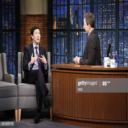




gold description:  vector illustration of little cute kid sitting on folding chair and drawing a picture with pencil.
system description:  computer graphics animation of cartoon boy in a mouse.


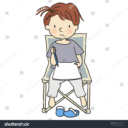




gold description:  tips for raising a friendly cat
system description:  happy family embracing each other


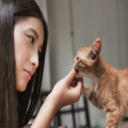




gold description:  moon on a dark sky at night
system description:  satellite shot of a moon


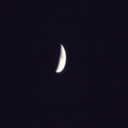




gold description:  young man is spending his vacation on a beach with a virtual reality glasses in black and white
system description:  religious leader with a big heart


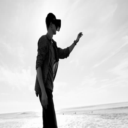




gold description:  builders discusses the problems of a construction
system description:  cottage houses are tourist attraction, and taking in some historic views


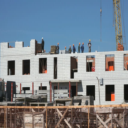




gold description:  person and soft rock artist pose in front of a field of young garlic
system description:  beards on a hill as the blue sky shines through village


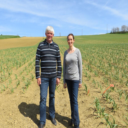




gold description:  tips for beautiful skin at any age # skincare
system description:  thinking about this issue of hair -- man who loves you like you love him while he gets dressed


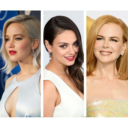




gold description:  music by shopping center, 50s, 60s & 70s
system description:  person ran around with a large - cage runner


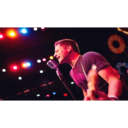




gold description:  award winner # poses for a portrait before a press conference to announce his signing.
system description:  rugby player celebrates scoring his 18th goal of the game


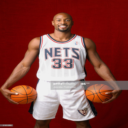




gold description:  football players look at the ball in the net after the 3'rd goal
system description:  person joins soccer player for a live friendly match.


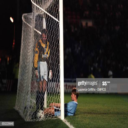




gold description:  comedian arrives to the premiere
system description:  basketball player poses at the press conference


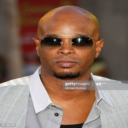




gold description:  the erosion, forming interesting formations and hoodoos
system description:  a mountain in the distance


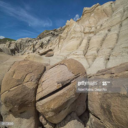




gold description:  entertainer proved that all work and no makes for a dull girl, as she headed for dinner in a plunging ensemble on wednesday.
system description:  actor arrives at the premiere of upcoming film at festival.


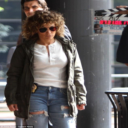




gold description:  view from one of the windows
system description:  window view of river from side of the hill.


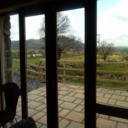




gold description:  the build up to the unknown : before we set sail
system description:  a blackout was set on top of a large yacht


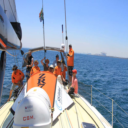




gold description:  a selection of standard puzzle pieces with different shapes
system description:  jigsaw puzzle and mystery puzzle were on display.


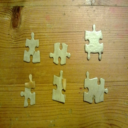




gold description:  head coach during a press conference.
system description:  actor attends the 10th annual general audience.


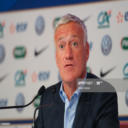




gold description:  morning mist on the lake
system description:  sailing above the national waters


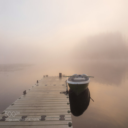




gold description:  water flows from the roof after the rain.
system description:  a lot of pipe and some pipes in front of this great wall


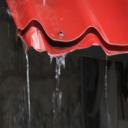




gold description:  looking for a dog sitter you found the right person
system description:  a life with narcissism - woman who lives her entire life but secretly approves of everyone she meets and waits for her first kiss


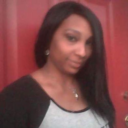




gold description:  a dressed up couple embracing in a city at industry
system description:  definitely going to happen at the premiere.


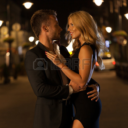




gold description:  country has more bears than any country save country
system description:  silhouette of a woman smiling at the camera


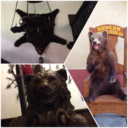




gold description:  zoom out from rows of sailboats docked at sunset under a partly cloudy sky, bathed in a soft orange light
system description:  aircraft and fireworks in the foreground


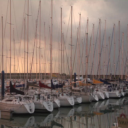




gold description:  actor stopping to get her daughter a cupcake while taking a walk through neighborhood
system description:  mom's hands on the ground


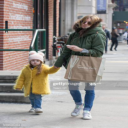




gold description:  close up of a hamster against a blurry background
system description:  fountain monkey vs beautiful dog in a cage, kittens


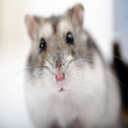




gold description:  actors arrive at the premiere of iron man held
system description:  singer attends a charity event.


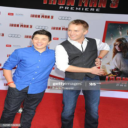




gold description:  bathroom on the first floor
system description:  modern design with classic glazed living room & serene carvings.


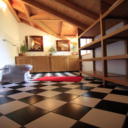




gold description:  government issued permit and a city
system description:  the sky in the background


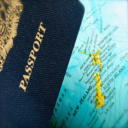




gold description:  pov of a freestyle skier who charges down a mountain
system description:  the young girl is walking down the road, alone


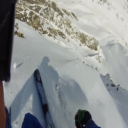




gold description:  baseball player poses during a photo day.
system description:  athlete poses with the trophy during the event


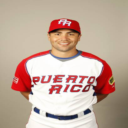




gold description:  group of young people is walking along the forest's trail on cloudy winter day
system description:  my bow as it gently moves away from me.


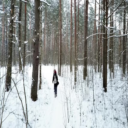




gold description:  politician pinches a girl's face.
system description:  family and friends at the fountain


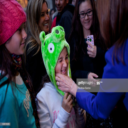




gold description:  in the jaws of winter
system description:  sheep at the back of the truck


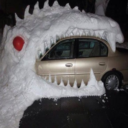




gold description:  noble person and princess attend private view and dinner for award.
system description:  actors arrive at the world premiere


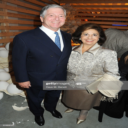




gold description:  person attends fashion business show during ss17
system description:  artist performs live on stage


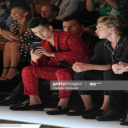




gold description:  the most iconic of all time is the hairstyle of actor.
system description:  a man with his eyebrows blurred and body slightly parted in silhouette.


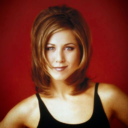




gold description:  external view of the building
system description:  a general view, some of the parking available during the event.


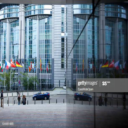




gold description:  food is so simple your kids could make it!
system description:  fruits and vegetables in general are a source of stress for many women and children.


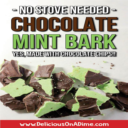




gold description:  a bust portrait of tribal chief a leader who lead a series of raids on white settlements
system description:  hard rock artist performs on stage.


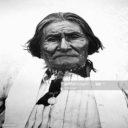




gold description:  pitcher comes out of the game in the 8th inning.
system description:  baseball player and person hold onto their baseball gloves in preparation for their fifth exhibition game.


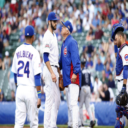




gold description:  a row of old teapots
system description:  actor opens a champagne bottle on the bench.


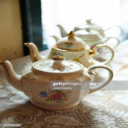




gold description:  although it was chilly i was drawn to the lush garden
system description:  art gallery, an example of early architecture


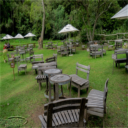




gold description:  flower & home marketplace : aisles just like this!
system description:  love the old spruce trees which are used as a backdrop for tables or outdoor decor.


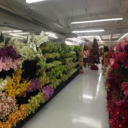




gold description:  the unique prototype currently has a place at the factory.
system description:  an auto body by automotive magazine


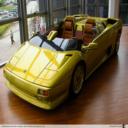




gold description:  a demonstrator shouts during protests.
system description:  people show up to parade


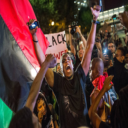




gold description:  person is one of the first customers.
system description:  person among the camping - out party for the young kids!


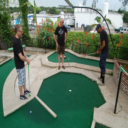




gold description:  a giant graffiti is drawn on a side wall of a building in district
system description:  the centre of the city


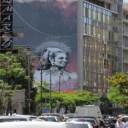




gold description:  glacier is connected with its neighbors in ways that threaten a wholesale collapse if it recedes too far inland.
system description:  an image of a bright sun illuminating the rocky islands


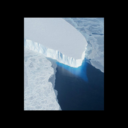




gold description:  fireworks display during tv special
system description:  the crowd after party during festival


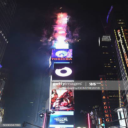




gold description:  business partners in conference room talking about new projects.
system description:  friends discussing new book with a pen in their hands


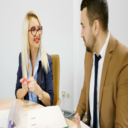




gold description:  gangsta rap artist performs live during day of festival.
system description:  pop artist performs during day of festival


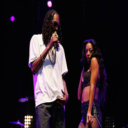

In [0]:
descriptor.eval()
with torch.no_grad():
    for idx, batch in enumerate(dataloader):
        for img, desc, _ in zip(*batch):
            print('gold description: ', descriptor.tokenizer.decode(desc, skip_special_tokens=True))
            processed_img = normalize(img)
            sampler.initialize(processed_img.unsqueeze(0))
            sys_desc = sampler.run()
            print('system description: ', descriptor.tokenizer.decode(sys_desc, skip_special_tokens=True))
            display(to_img(img))
            print('\n\n')
        if idx > 3:
            break